In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.6616123340747975
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.6715371873643663
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.6689833888301143
Checkpoint 400, Accuracy: 0.8333333333333334, Loss: 0.6689833888301143
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.6701607174343533


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [[0.72815466]
 [0.17216627]
 [0.09967909]]
[0. 0. 1.] <-> [[0.16857661]
 [0.3497118 ]
 [0.48171157]]
[1. 0. 0.] <-> [[0.57163244]
 [0.24680401]
 [0.18156357]]
[1. 0. 0.] <-> [[0.49724838]
 [0.27697256]
 [0.2257791 ]]
[0. 0. 1.] <-> [[0.24268706]
 [0.3457415 ]
 [0.4115714 ]]
[0. 1. 0.] <-> [[0.48261797]
 [0.28246963]
 [0.2349124 ]]
[1. 0. 0.] <-> [[0.8621128 ]
 [0.09615088]
 [0.0417363 ]]
[0. 0. 1.] <-> [[0.88488245]
 [0.08191227]
 [0.03320524]]
[0. 0. 1.] <-> [[0.6817655 ]
 [0.1958163 ]
 [0.12241822]]
[1. 0. 0.] <-> [[0.5058273 ]
 [0.27368006]
 [0.22049262]]
[1. 0. 0.] <-> [[0.6934443 ]
 [0.18998384]
 [0.11657188]]
[0. 1. 0.] <-> [[0.2807355 ]
 [0.33998471]
 [0.37927976]]
[0. 0. 1.] <-> [[0.4151386 ]
 [0.30577976]
 [0.27908164]]
[1. 0. 0.] <-> [[0.652472  ]
 [0.21008818]
 [0.13743982]]
[1. 0. 0.] <-> [[0.8318939 ]
 [0.1143924 ]
 [0.05371367]]
[0. 1. 0.] <-> [[0.6782091 ]
 [0.19757621]
 [0.12421469]]
[1. 0. 0.] <-> [[0.6475178 ]
 [0.2124514 ]
 [0.14003079]]
[1. 0. 0.] <->

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


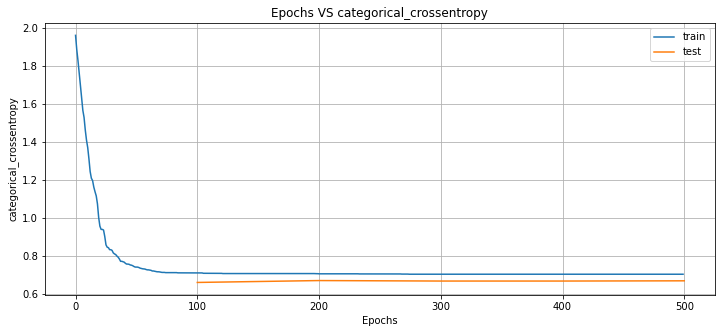

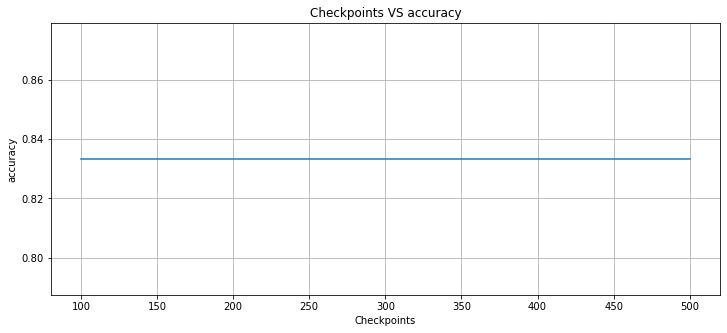

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8333333333333334, 'mean_square_error': 2.817319370447772, 'categorical_crossentropy': 0.6616123340747975, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.759496874563959, 'categorical_crossentropy': 0.6715371873643663, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.7884342611139683, 'categorical_crossentropy': 0.6689833888301143, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit'

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[-0.08151314]
 [-0.05767588]
 [-0.23013863]
 [-0.29085144]
 [-0.31006414]]
 bias: [0.51683766]

Neuron 1: weights:
[[-0.36373922]
 [-0.0912688 ]
 [-0.01459945]
 [-0.17477018]
 [-0.27388737]]
 bias: [0.2906486]

Neuron 2: weights:
[[0.23811178]
 [0.03412993]
 [0.1031636 ]
 [0.16910577]
 [0.20484495]]
 bias: [-0.10872912]

Neuron 3: weights:
[[0.20764294]
 [0.29645005]
 [0.11680724]
 [0.17954999]
 [0.02572947]]
 bias: [-0.30472454]

$
Layer 2
Neuron 0: weights:
[[ 0.893979  ]
 [ 0.92430013]
 [-0.63006914]
 [-0.5672323 ]]
 bias: [0.43928757]

Neuron 1: weights:
[[-0.09704604]
 [-0.29693782]
 [ 0.13200855]
 [ 0.07694529]]
 bias: [-0.16060145]

Neuron 2: weights:
[[-0.75478584]
 [-0.65051913]
 [ 0.23085928]
 [ 0.36502945]]
 bias: [-0.2001384]

$

